<a href="https://colab.research.google.com/github/RichardZhu123/AndroidThingSureLockedHome/blob/master/Independent_Work_S22_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Imports and Setup

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.nn.utils.rnn import PackedSequence
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
from torch import nn
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
  device = torch.device("cuda")
  print("Using GPU")
else:
  device = torch.device("cpu")
  print("Using CPU")

Using GPU


# 2. Importing and Pre-Processing Data

In [5]:
# import data
sudoku_df = pd.read_csv('/content/drive/My Drive/Independent Work/sudoku.csv')
sudoku_df.head()

,quizzes,solutions
0,0043002090050090010700600430060020871900074000...,8643712593258497619712658434361925871986574322...
1,0401000501070039605200080000000000170009068008...,3461792581875239645296483719658324174729168358...
2,6001203840084590720000060050002640300700800069...,6951273841384596727248369158512647392739815469...
3,4972000001004000050000160986203000403009000000...,4972583161864397252537164986293815473759641828...
4,0059103080094030600275001000300002010008200070...,4659123781894735623275681497386452919548216372...


In [6]:
n = len(sudoku_df.index) # Total number of examples in dataset
train_x = [[int(c) for c in s] for s in sudoku_df.loc[:0.01*n, "quizzes"].to_numpy()]
dev_x = [[int(c) for c in s] for s in sudoku_df.loc[0.94*n:0.95*n, "quizzes"].to_numpy()]
test_x = [[int(c) for c in s] for s in sudoku_df.loc[0.99*n:, "quizzes"].to_numpy()]

train_y = [[int(c) for c in s] for s in sudoku_df.loc[:0.01*n, "solutions"].to_numpy()]
dev_y = [[int(c) for c in s] for s in sudoku_df.loc[0.94*n:0.95*n, "solutions"].to_numpy()]
test_y = [[int(c) for c in s] for s in sudoku_df.loc[0.99*n:, "solutions"].to_numpy()]

In [7]:
v = 10 # vocab size of values from 0 - 9
puz_dim = 81 # dimension of puzzle, in this case there are 81 cells in a 9x9 grid

# seq is sequence, v is vocab/dict size, puz_dim is dimension of puzzle (81 for 9x9)
# and batch_size is the size of each batch
def one_hot_encode(seq, v, puz_dim, batch_size=256):
  features = np.zeros((len(seq), puz_dim, v), dtype=np.int32)

  for i in range(len(seq)):
    for j in range(puz_dim):
      features[i, j, seq[i][j]] = 1
  features = torch.Tensor(features)
  return torch.split(features, batch_size)

# turn the sequence into a batched input with batch size bt_sz
def batch(input, bt_sz):
  l = len(input)
  ft_batched = np.zeros(bt_sz)
  for i in range(0, l, bt_sz):
    ft_batched = input[i:min(i+bt_sz, l)]
  return ft_batched


In [8]:
# encode train set
batch_size = 256
tx_seq = one_hot_encode(train_x, v, puz_dim, batch_size)

# train_x and train_y in sequence form
ty_seq = torch.split(torch.Tensor(train_y), batch_size)

# 3a. Training the Vanilla RNN

In [ ]:
class RNNModel(nn.Module):
  # bi - bidirectional, false by default
  def __init__(self, input_size, output_size, hidden_dim, n_layers, bi=False):
    super(RNNModel, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.output_size = output_size
    self.d = 2 if bi else 1

    self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=bi)
    self.fc = nn.Linear(self.d*hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)
    hidden = torch.randn(self.d*self.n_layers, batch_size, self.hidden_dim)
    hidden = hidden.to(device)
    out, hidden = self.rnn(x, hidden)
    out = self.fc(out)
    out = torch.transpose(out, 1, 2)

    # out = out.contiguous().view(-1, self.hidden_dim)
    # out = self.fc(out)

    return out, hidden

# returns list of prediction. puz_seq is a tensor of the puzzle (eg. 1x81 for a 9x9 puzzle)
def predict(model, puz_seq):
    out, _ = model(puz_seq)
    out = torch.nn.functional.softmax(out, dim=1)
    _, out = out.max(dim=1)
    return out

In [ ]:
# Init model
rnnModel = RNNModel(input_size=v, output_size=v, hidden_dim=100, n_layers=2, bi=True).to(device)
if is_cuda:
  print("Using GPU")
else:
  print("Using CPU")

# Hyperparameters
n_epochs = 50
lr = 0.01 # initial learning rate. learning rate decreases by exp decay
decay_rate = 0.997

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnnModel.parameters(), lr=lr)

# Scheduler facilitates exponential decay of learning rate over epochs
lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay_rate)

In [ ]:
# Begin training
losses = []
for epoch in range(1, n_epochs + 1):
  for tx_bat, ty_bat in zip(tx_seq, ty_seq):
    tx_bat = tx_bat.to(device)
    ty_bat = ty_bat.to(device)
    optimizer.zero_grad()
    output, hidden = rnnModel(tx_bat)
    #loss = criterion(output, ty_seq.view(-1).long())
    loss = criterion(output, ty_bat.long())
    loss.backward()
    optimizer.step()
    lr_sched.step()

  losses.append(loss.item())
  if epoch % 10 == 0: 
    print("Epoch: {}/{}..........".format(epoch, n_epochs))
    #print("Learning Rate:", lr_sched.get_last_lr())
    print("Loss: {:.4f}".format(loss.item()))

In [ ]:
plt.plot(range(1, n_epochs + 1), losses)
plt.title("Bidirectional RNN Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

# 3b. Training the Long Short-Term Memory Model

In [9]:
class LSTMModel(nn.Module):
  # bi - bidirectional, false by default
  def __init__(self, input_size, output_size, hidden_dim, n_layers, bi=False):
    super(LSTMModel, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.output_size = output_size
    self.d = 2 if bi else 1

    self.lstm = nn.LSTM(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=bi)
    self.fc = nn.Linear(self.d*hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)
    hidden = torch.randn(self.d*self.n_layers, batch_size, self.hidden_dim).to(device)
    cell = torch.randn(self.d*self.n_layers, batch_size, self.hidden_dim).to(device)
    out, (_, _) = self.lstm(x, (hidden, cell))
    out = self.fc(out)
    out = torch.transpose(out, 1, 2)

    # out = out.contiguous().view(-1, self.hidden_dim)
    # out = self.fc(out)

    return out, hidden

# returns list of prediction. puz_seq is a tensor of the puzzle (eg. 1x81 for a 9x9 puzzle)
def predict(model, puz_seq):
    out, _ = model(puz_seq)
    out = torch.nn.functional.softmax(out, dim=1)
    _, out = out.max(dim=1)
    return out

In [17]:
# Init model
lstmModel = LSTMModel(input_size=v, output_size=v, hidden_dim=100, n_layers=3, bi=True)
if is_cuda:
  lstmModel.cuda()
  print("Using GPU")
else:
  print("Using CPU")

# Hyperparameters
n_epochs = 100
lr = 0.01 # initial learning rate. learning rate decreases by exp decay
decay_rate = 0.998

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstmModel.parameters(), lr=lr)

# Scheduler facilitates exponential decay of learning rate over epochs
lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay_rate)

Using GPU


In [19]:
# Begin training
losses = []
for epoch in range(1, n_epochs + 1):
  for tx_bat, ty_bat in zip(tx_seq, ty_seq):
    tx_bat = tx_bat.to(device)
    ty_bat = ty_bat.to(device)
    optimizer.zero_grad()
    output, hidden = lstmModel(tx_bat)
    #loss = criterion(output, ty_seq.view(-1).long())
    loss = criterion(output, ty_bat.long())
    loss.backward()
    optimizer.step()
    lr_sched.step()

  losses.append(loss.item())
  if epoch % 1 == 0: 
    print("Epoch: {}/{}..........".format(epoch, n_epochs))
    #print("Learning Rate:", lr_sched.get_last_lr())
    print("Loss: {:.4f}".format(loss.item()))

Epoch: 1/100..........
Loss: 1.1196
Epoch: 2/100..........
Loss: 1.1414
Epoch: 3/100..........
Loss: 1.0890
Epoch: 4/100..........
Loss: 1.1274
Epoch: 5/100..........
Loss: 1.0372
Epoch: 6/100..........
Loss: 0.9814
Epoch: 7/100..........
Loss: 0.9392
Epoch: 8/100..........
Loss: 0.9158
Epoch: 9/100..........
Loss: 0.8743
Epoch: 10/100..........
Loss: 0.8567
Epoch: 11/100..........
Loss: 0.7972
Epoch: 12/100..........
Loss: 0.7642
Epoch: 13/100..........
Loss: 0.7640
Epoch: 14/100..........
Loss: 0.7339
Epoch: 15/100..........
Loss: 0.6927
Epoch: 16/100..........
Loss: 0.6627
Epoch: 17/100..........
Loss: 0.6430
Epoch: 18/100..........
Loss: 0.6471
Epoch: 19/100..........
Loss: 0.6059
Epoch: 20/100..........
Loss: 0.6408
Epoch: 21/100..........
Loss: 0.6053
Epoch: 22/100..........
Loss: 0.5667
Epoch: 23/100..........
Loss: 0.5520
Epoch: 24/100..........
Loss: 0.5327
Epoch: 25/100..........
Loss: 0.5719
Epoch: 26/100..........
Loss: 0.5100
Epoch: 27/100..........
Loss: 0.4917
Epoch: 28/

Text(0, 0.5, 'Cross Entropy Loss')

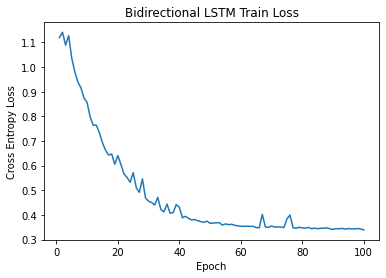

In [20]:
plt.plot(range(1, n_epochs + 1), losses)
plt.title("Bidirectional LSTM Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

# 3c. Training the GRU

In [ ]:
class GRUModel(nn.Module):
  # bi - bidirectional, false by default
  def __init__(self, input_size, output_size, hidden_dim, n_layers, bi=False):
    super(GRUModel, self).__init__()

    self.hidden_dim = hidden_dim
    self.n_layers = n_layers
    self.output_size = output_size
    self.d = 2 if bi else 1

    self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True, bidirectional=bi)
    self.fc = nn.Linear(self.d*hidden_dim, output_size)

  def forward(self, x):
    batch_size = x.size(0)
    hidden = torch.randn(self.d*self.n_layers, batch_size, self.hidden_dim).to(device)
    out, _ = self.gru(x, hidden)
    out = self.fc(out)
    out = torch.transpose(out, 1, 2)

    # out = out.contiguous().view(-1, self.hidden_dim)
    # out = self.fc(out)

    return out, hidden

# returns list of prediction. puz_seq is a tensor of the puzzle (eg. 1x81 for a 9x9 puzzle)
def predict(model, puz_seq):
    out, _ = model(puz_seq)
    out = torch.nn.functional.softmax(out, dim=1)
    _, out = out.max(dim=1)
    return out

In [ ]:
# Init model
gruModel = GRUModel(input_size=v, output_size=v, hidden_dim=100, n_layers=2, bi=True)
if is_cuda:
  gruModel.cuda()
  print("Using GPU")
else:
  print("Using CPU")

# Hyperparameters
n_epochs = 100
lr = 0.01 # initial learning rate. learning rate decreases by exp decay
decay_rate = 0.998

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gruModel.parameters(), lr=lr)

# Scheduler facilitates exponential decay of learning rate over epochs
lr_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer, decay_rate)

Using GPU


In [ ]:
# Begin training
losses = []
for epoch in range(1, n_epochs + 1):
  for tx_bat, ty_bat in zip(tx_seq, ty_seq):
    tx_bat = tx_bat.to(device)
    ty_bat = ty_bat.to(device)
    optimizer.zero_grad()
    output, hidden = gruModel(tx_bat)
    #loss = criterion(output, ty_seq.view(-1).long())
    loss = criterion(output, ty_bat.long())
    loss.backward()
    optimizer.step()
    lr_sched.step()

  losses.append(loss.item())
  if epoch % 1 == 0: 
    print("Epoch: {}/{}..........".format(epoch, n_epochs))
    #print("Learning Rate:", lr_sched.get_last_lr())
    print("Loss: {:.4f}".format(loss.item()))

Epoch: 1/100..........
Loss: 1.2465
Epoch: 2/100..........
Loss: 1.2022
Epoch: 3/100..........
Loss: 1.1713
Epoch: 4/100..........
Loss: 1.1449
Epoch: 5/100..........
Loss: 1.1239
Epoch: 6/100..........
Loss: 1.1002
Epoch: 7/100..........
Loss: 1.0670
Epoch: 8/100..........
Loss: 1.0592
Epoch: 9/100..........
Loss: 1.1452
Epoch: 10/100..........
Loss: 1.0404
Epoch: 11/100..........
Loss: 0.9730
Epoch: 12/100..........
Loss: 0.9803
Epoch: 13/100..........
Loss: 0.9309
Epoch: 14/100..........
Loss: 0.9111
Epoch: 15/100..........
Loss: 0.8231
Epoch: 16/100..........
Loss: 0.7824
Epoch: 17/100..........
Loss: 0.7503
Epoch: 18/100..........
Loss: 0.7023
Epoch: 19/100..........
Loss: 0.6735
Epoch: 20/100..........
Loss: 0.6353
Epoch: 21/100..........
Loss: 0.5989
Epoch: 22/100..........
Loss: 0.5954
Epoch: 23/100..........
Loss: 0.5539
Epoch: 24/100..........
Loss: 0.5323
Epoch: 25/100..........
Loss: 0.5090
Epoch: 26/100..........
Loss: 0.4865
Epoch: 27/100..........
Loss: 0.4706
Epoch: 28/

Text(0, 0.5, 'Cross Entropy Loss')

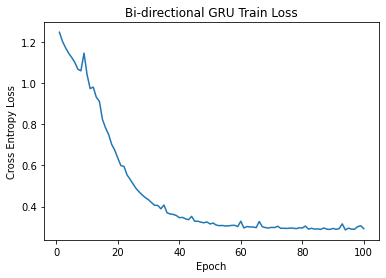

In [ ]:
plt.plot(range(1, n_epochs + 1), losses)
plt.title("Bi-directional GRU Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")

#4. Testing and Evaluation

In [21]:
# no of parameters in model
print(sum(param.numel() for param in lstmModel.parameters() if param.requires_grad))

574810


In [22]:
puz_seq = one_hot_encode(dev_x, v, puz_dim, batch_size)
ans_seq = torch.split(torch.Tensor(dev_y), batch_size)

pred = []
for dx_bat in puz_seq:
  dx_bat = dx_bat.to(device)
  pred.append(predict(lstmModel, dx_bat.float()).cpu())

pred = np.concatenate(pred)

In [23]:
print(np.shape(pred))
print(np.shape(dev_x))

(10001, 81)
(10001, 81)


In [24]:
# Evaluate on train set
num_total = len(train_x) * 81 # total number of cells across entire set
puz_seq = one_hot_encode(train_x, v, puz_dim, batch_size)

t_pred = []
for tx_bat in puz_seq:
  tx_bat = tx_bat.to(device)
  t_pred.append(predict(lstmModel, tx_bat.float()).cpu())
t_pred = np.concatenate(t_pred)

num_correct = (t_pred == train_y).sum().item()
print(num_correct/num_total*100,"%")

68.0406033470727 %


In [25]:
# Evaluate on dev set
num_total = len(dev_x) * 81 # total number of cells across entire set
puz_seq = one_hot_encode(dev_x, v, puz_dim, batch_size)

d_pred = []
for dx_bat in puz_seq:
  dx_bat = dx_bat.to(device)
  d_pred.append(predict(lstmModel, dx_bat.float()).cpu())
d_pred = np.concatenate(d_pred)

num_correct = (d_pred == dev_y).sum().item()
print(num_correct/num_total*100,"%")

64.93819753827086 %


In [26]:
# Evaluate on test set
num_total = len(test_x) * 81 # total number of cells across entire set
puz_seq = one_hot_encode(test_x, v, puz_dim, batch_size)

tt_pred = []
for ttx_bat in puz_seq:
  ttx_bat = ttx_bat.to(device)
  tt_pred.append(predict(lstmModel, ttx_bat.float()).cpu())
tt_pred = np.concatenate(tt_pred)

num_correct = (tt_pred == test_y).sum().item()
print(num_correct/num_total*100,"%")

65.06086419753086 %


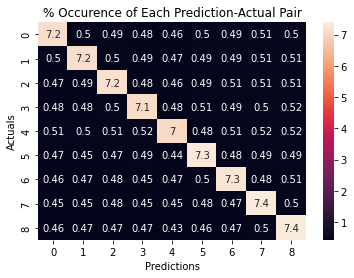

In [27]:
cf_matrix = np.round(confusion_matrix(np.array(test_y).reshape(-1), tt_pred.reshape(-1)) / (len(test_x)*81) * 100, 2)
ax = plt.axes()
sns.heatmap(cf_matrix, annot=True, ax=ax)
ax.set_title("% Occurence of Each Prediction-Actual Pair")
ax.set_xlabel("Predictions")
ax.set_ylabel("Actuals")
plt.show()

In [28]:
# examine the first test prediction and gold value
print("prompt:", test_x[0])
print("pred:", list(tt_pred[0]))
print("gold:", test_y[0])

prompt: [0, 0, 7, 8, 0, 3, 0, 0, 0, 0, 0, 1, 0, 6, 0, 0, 0, 2, 8, 3, 0, 0, 5, 0, 0, 0, 4, 0, 2, 0, 0, 7, 0, 9, 0, 5, 5, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 9, 0, 0, 3, 0, 1, 0, 5, 4, 0, 2, 0, 0, 8, 0, 9, 0, 6, 0, 0, 0, 0, 0, 0, 7, 3, 5, 8, 0, 4, 6, 1]
pred: [4, 6, 7, 8, 2, 3, 1, 1, 5, 5, 4, 1, 9, 6, 9, 8, 8, 2, 8, 3, 6, 2, 5, 2, 7, 6, 4, 3, 2, 3, 1, 7, 1, 9, 4, 5, 5, 9, 9, 8, 3, 3, 1, 2, 7, 6, 7, 7, 5, 9, 2, 8, 3, 6, 1, 6, 5, 4, 9, 2, 7, 3, 8, 8, 9, 8, 6, 1, 1, 5, 5, 5, 2, 7, 3, 5, 8, 9, 4, 6, 1]
gold: [6, 4, 7, 8, 2, 3, 5, 1, 9, 9, 5, 1, 7, 6, 4, 3, 8, 2, 8, 3, 2, 9, 5, 1, 6, 7, 4, 3, 2, 6, 1, 7, 8, 9, 4, 5, 5, 8, 9, 3, 4, 6, 1, 2, 7, 7, 1, 4, 2, 9, 5, 8, 3, 6, 1, 6, 5, 4, 3, 2, 7, 9, 8, 4, 9, 8, 6, 1, 7, 2, 5, 3, 2, 7, 3, 5, 8, 9, 4, 6, 1]
